# Fake/Real News Classification
reference: https://www.kaggle.com/code/jonathanlam1014/fake-news-headlines-classification

In [1]:
import numpy as np 
import pandas as pd 

## load dataset

In [2]:
#Read Dataset
Headlines = pd.read_csv('./input/abcnews-date-text.csv', usecols =["headline_text"]).dropna()
Fake = pd.read_csv('./input/Fake.csv', usecols =["title"]).dropna()
Fake2 = pd.read_csv('./input/Fake 2.csv', usecols =["title"]).dropna()

In [3]:
#Removing duplicated headlines
Headlines = Headlines.drop_duplicates('headline_text')
Fake = Fake.drop_duplicates('title')
Fake2 = Fake2.drop_duplicates('title')

In [4]:
Fake = Fake.rename(columns={'title': 'headline_text'})
Fake2 = Fake2.rename(columns={'title': 'headline_text'})

- Headline - real(fake=0)
- Fake     - fake(fake=1)

In [5]:
Headlines['fake'] = 0
Fake['fake'] = 1
Fake2['fake'] = 1

In [6]:
# Downsize million-headlines dataset to first 50K rows
Headlines = Headlines.head(50000)
fake_headline = pd.concat([Fake, Fake2], ignore_index=True)
fake_headline = fake_headline.rename(columns={'title': 'headline_text'})
print('Training dataset contains: {} Real headlines and {} Fake headlines.'.format(len(Headlines),len(Fake)+len(Fake2)))

Training dataset contains: 50000 Real headlines and 29601 Fake headlines.


In [7]:
Headlines = Headlines.head(25000)
fake_headline = fake_headline.head(25000)
train = pd.concat([fake_headline, Headlines], ignore_index=True)

In [8]:
train.head()

,headline_text,fake
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


In [9]:
%pip install gensim nltk scikit-learn

import gensim
import nltk as nl
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk_stopwords = nl.corpus.stopwords.words('english')
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords, gensim_stopwords)

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.


In [10]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [11]:
from nltk.stem import PorterStemmer 
porter_stemmer = PorterStemmer() 

In [12]:
train['headline_text'] = train['headline_text'].apply(lambda x: x.lower())
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
train['headline_text'] = train['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

In [13]:
train.head()

,headline_text,fake
0,donald trump send embarrass new eve thi disturb,1
1,drunk brag trump staffer start russian collus ...,1
2,sheriff david clark becom internet joke threat...,1
3,trump obsess ha code hi websit,1
4,pope franci donald trump dure hi christma speech,1


In [14]:
# split the dataset into training and validation datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['headline_text'], train['fake'], test_size=0.2)


## Construct model use TF-IDF

In [15]:
# construct models use TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



from keras.models import Sequential # type: ignore
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D, LSTM, Bidirectional, GRU # type: ignore
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from keras import regularizers

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


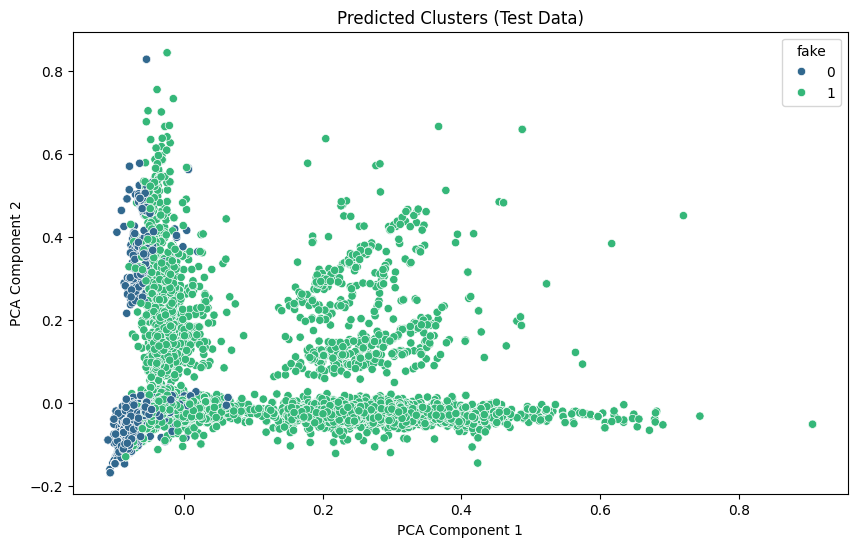

In [17]:
# visualize the classified results with labels
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
train_pca = pca.fit_transform(tfidf_train)
test_pca = pca.transform(tfidf_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(train_pca[:,0], train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [18]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC(kernel='linear')
knn = KNeighborsClassifier()
nb = MultinomialNB()
gb = GradientBoostingClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

models = [dt, rf, svc, knn, nb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

for model, name in zip(models, model_names):
    model.fit(tfidf_train, y_train)
    pred = model.predict(tfidf_test)
    print(name)
    print('Accuracy: ', accuracy_score(y_test, pred))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix ({})'.format(name))
    plt.show()
    

Decision Tree
Accuracy:  0.8433
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      4954
           1       0.90      0.78      0.83      5046

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

[[4495  459]
 [1108 3938]]
Random Forest
Accuracy:  0.8558
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4954
           1       0.91      0.79      0.85      5046

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4557  397]
 [1045 4001]]
SVM
Accuracy:  0.857
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      4954
           1       0.92      0.79      0.85      5046

    accuracy                           0.86

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Accuracy:  0.8184
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      4954
           1       0.95      0.67      0.79      5046

    accuracy                           0.82     10000
   macro avg       0.85      0.82      0.81     10000
weighted avg       0.85      0.82      0.81     10000

[[4786  168]
 [1648 3398]]
XGBoost
Accuracy:  0.8512
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      4954
           1       0.95      0.74      0.83      5046

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000

[[4757  197]
 [1291 3755]]
[LightGBM] [Info] Number of positive: 19954, number of negative: 20046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

In [19]:
print ("Testing Acc. of Decision Tree: {} %".format(round(dt.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of Random Forest: {} %".format(round(rf.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of SVC: {} %".format(round(svc.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of K-NN: {} %".format(round(knn.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of Naive Bayesian: {} %".format(round(nb.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of Gradient Boosting: {} %".format(round(gb.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of AdaBoost: {} %".format(round(ada.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of XGBoost: {} %".format(round(xgb.score(tfidf_test, y_test) * 100, 2)))
print ("Testing Acc. of LGBM: {} %".format(round(lgbm.score(tfidf_test, y_test) * 100, 2)))

Testing Acc. of Decision Tree: 84.33 %
Testing Acc. of Random Forest: 85.58 %
Testing Acc. of SVC: 85.7 %
Testing Acc. of K-NN: 75.72 %
Testing Acc. of Naive Bayesian: 84.93 %
Testing Acc. of Gradient Boosting: 79.94 %
Testing Acc. of AdaBoost: 81.84 %
Testing Acc. of XGBoost: 85.12 %
Testing Acc. of LGBM: 85.87 %


Decision Tree Confusion Matrix:
[[4495  459]
 [1108 3938]]


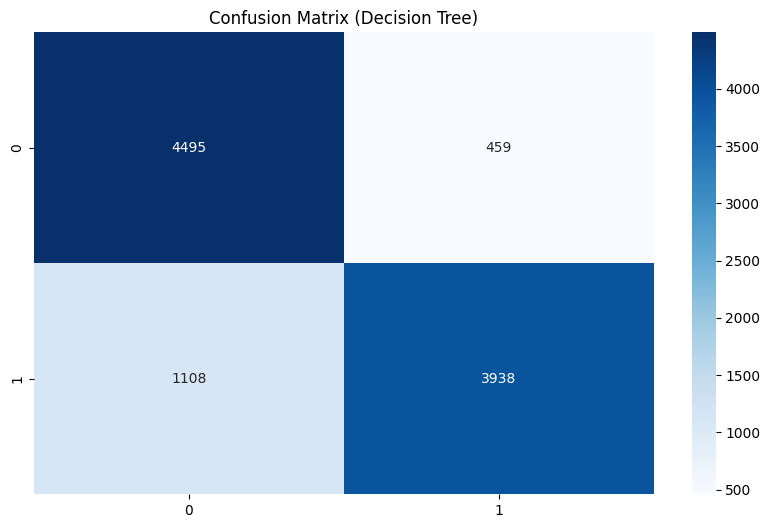

Random Forest Confusion Matrix:
[[4557  397]
 [1045 4001]]


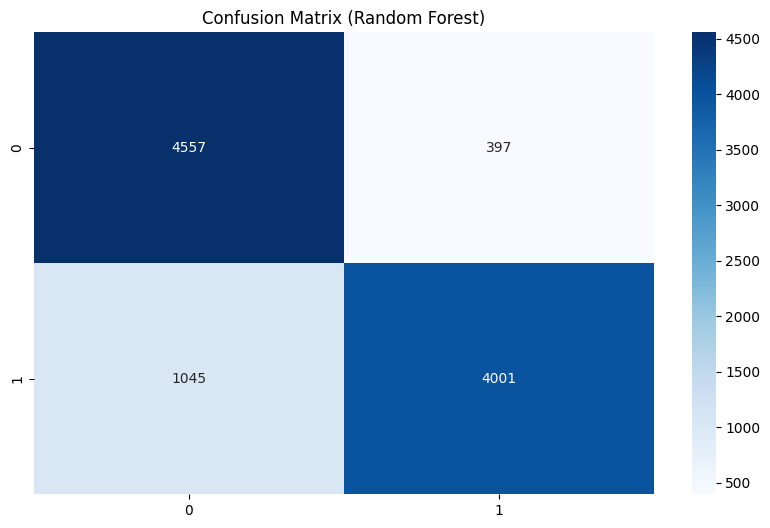

SVC Confusion Matrix:
[[4592  362]
 [1068 3978]]


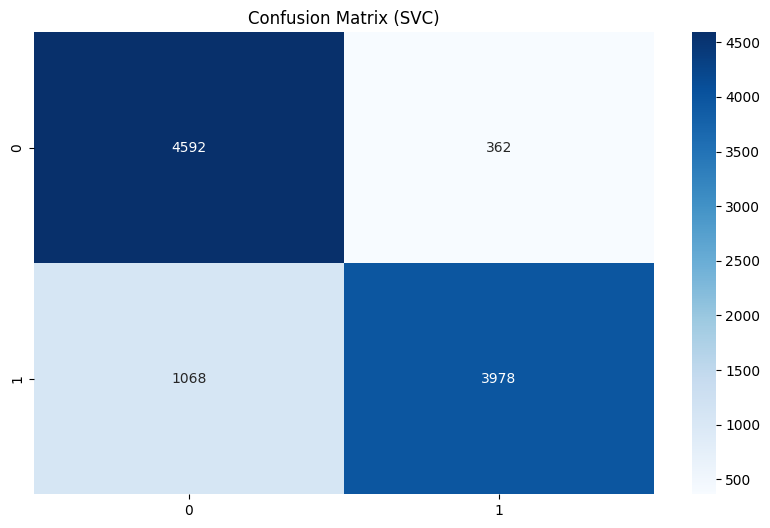

K-NN Confusion Matrix:
[[3683 1271]
 [1157 3889]]


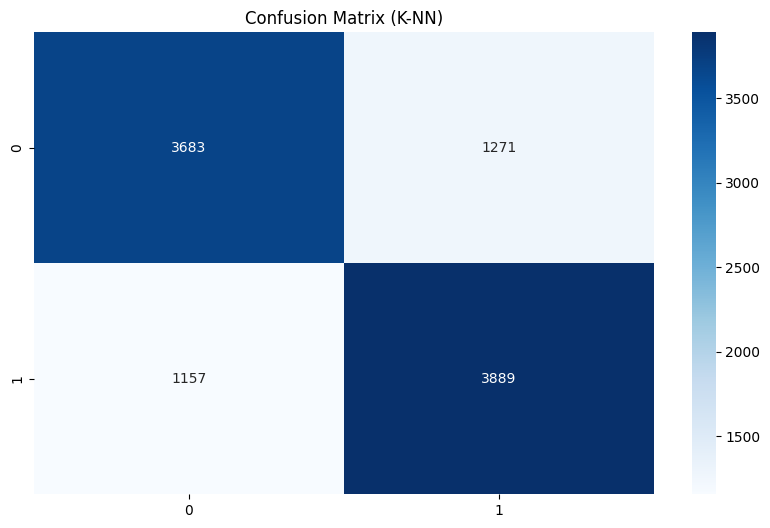

Naive Bayesian Confusion Matrix:
[[4453  501]
 [1006 4040]]


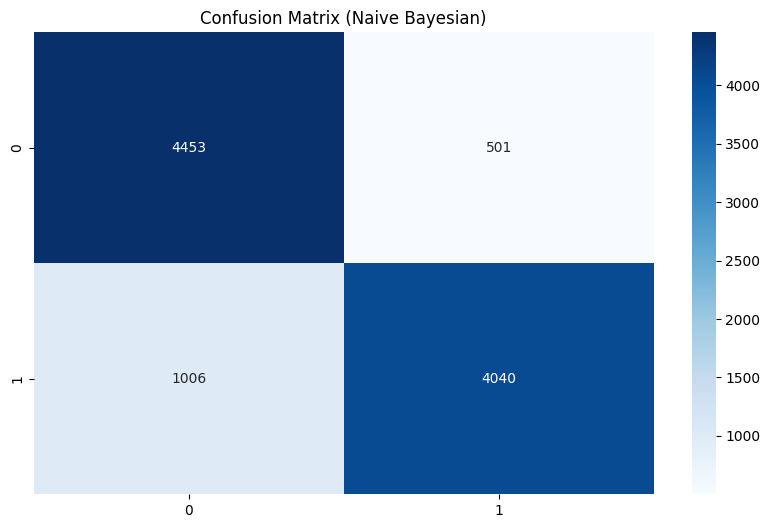

Gradient Boosting Confusion Matrix:
[[4860   94]
 [1912 3134]]


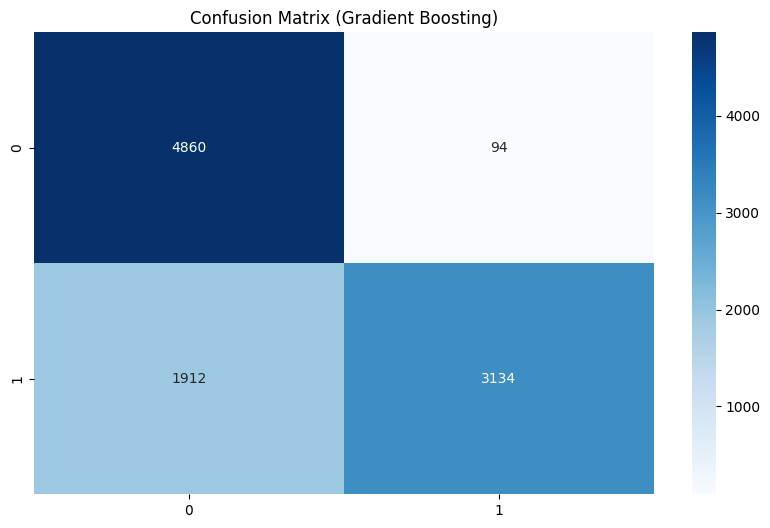

AdaBoost Confusion Matrix:
[[4786  168]
 [1648 3398]]


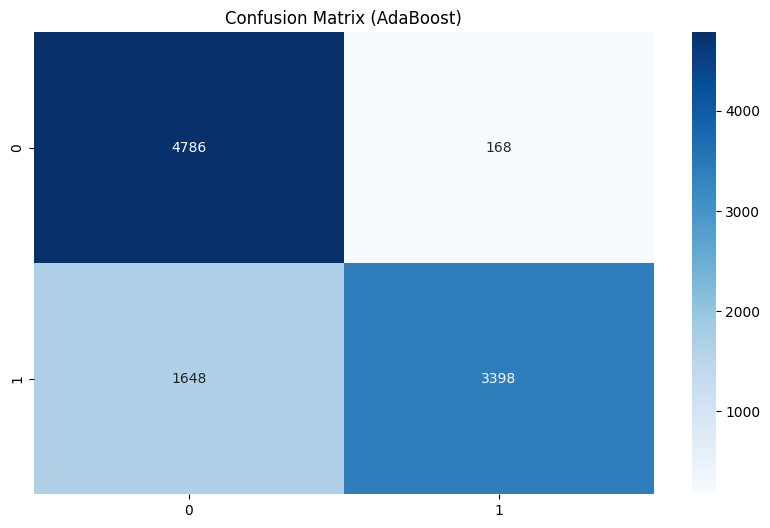

XGBoost Confusion Matrix:
[[4757  197]
 [1291 3755]]


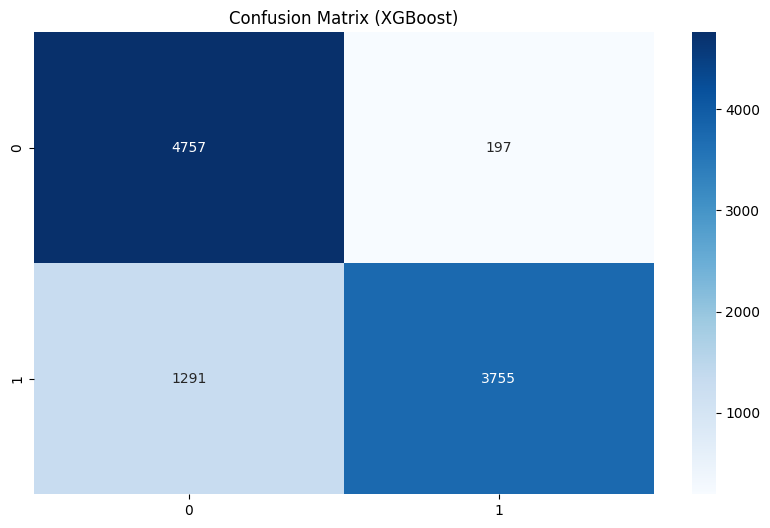

LGBM Confusion Matrix:
[[4682  272]
 [1141 3905]]


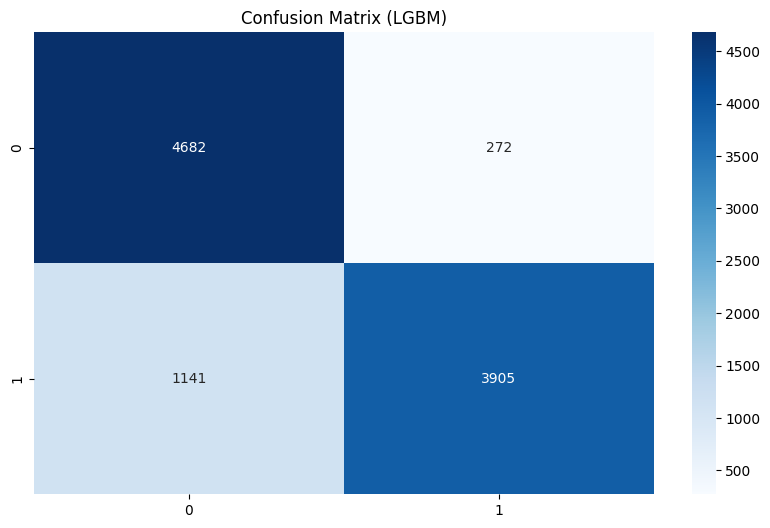

In [20]:
# confusion matrix with visualized heatmap
y_pred = dt.predict(tfidf_test)
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

y_pred = rf.predict(tfidf_test)
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

y_pred = svc.predict(tfidf_test)
print("SVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVC)')
plt.show()

y_pred = knn.predict(tfidf_test)
print("K-NN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (K-NN)')
plt.show()

y_pred = nb.predict(tfidf_test)
print("Naive Bayesian Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Naive Bayesian)')
plt.show()

y_pred = gb.predict(tfidf_test)
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.show()

y_pred = ada.predict(tfidf_test)
print("AdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (AdaBoost)')
plt.show()

y_pred = xgb.predict(tfidf_test)
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

y_pred = lgbm.predict(tfidf_test)
print("LGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (LGBM)')
plt.show()

# construct models use TFIDF

In [21]:
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

neural_network = Sequential()
neural_network.add(Dense(64, input_dim=len(tfidf_features), activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(tfidf_train, y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(tfidf_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 85.84 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
DNN Confusion Matrix:
[[4619  335]
 [1081 3965]]


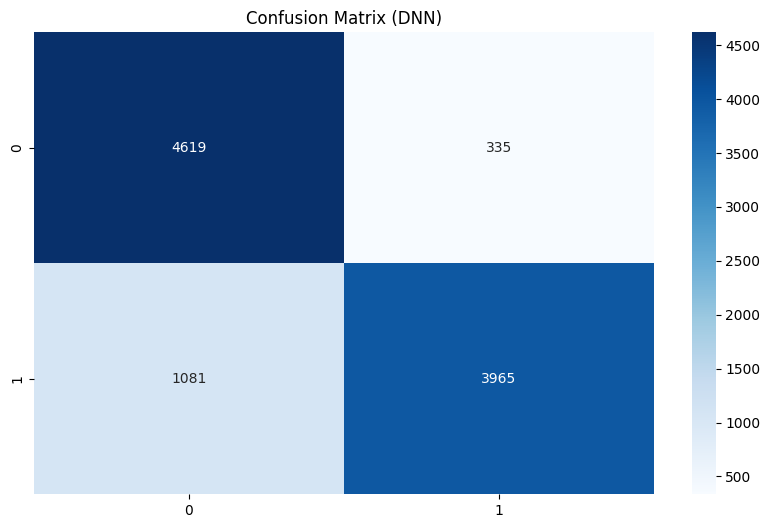

In [22]:
# confusion matrix of DNN
y_pred = (neural_network.predict(tfidf_test) > 0.5).astype("int32")
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()


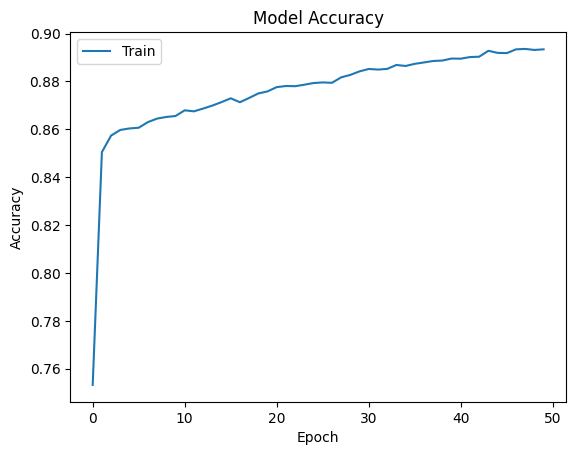

In [23]:
# visualize the model Accuracy-DNN

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

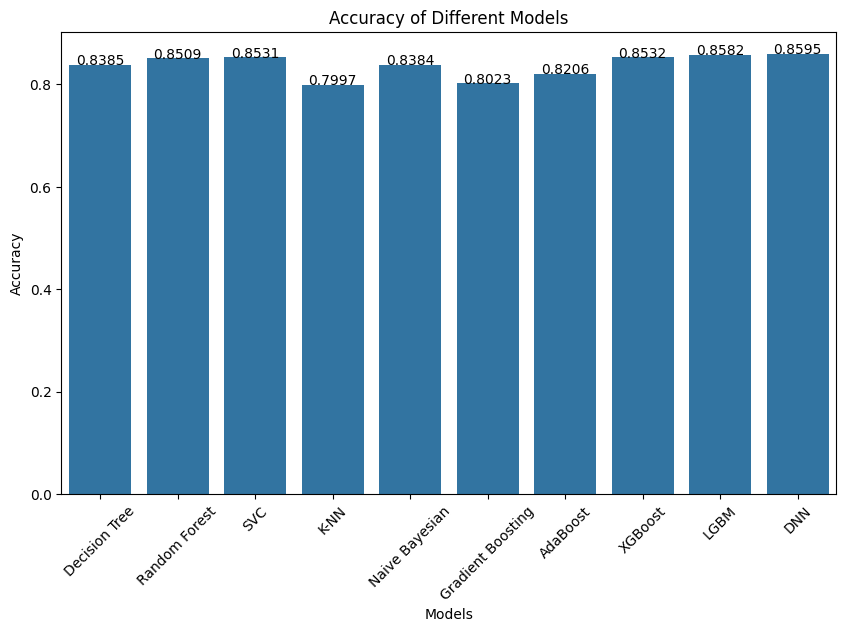

In [24]:
# visualize accuracy of different models

models = ['Decision Tree', 'Random Forest', 'SVC', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.8385, 0.8509, 0.8531, 0.7997, 0.8384, 0.8023, 0.8206, 0.8532, 0.8582, 0.8595]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on TF-IDF')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()

## Construct model use counter vectorizer

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# create a count vectorizer object
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['headline_text'])

# transform the training and validation data using count vectorizer object
xtrain_count = count_vect.transform(x_train).astype(np.float64)
xvalid_count = count_vect.transform(x_test).astype(np.float64)

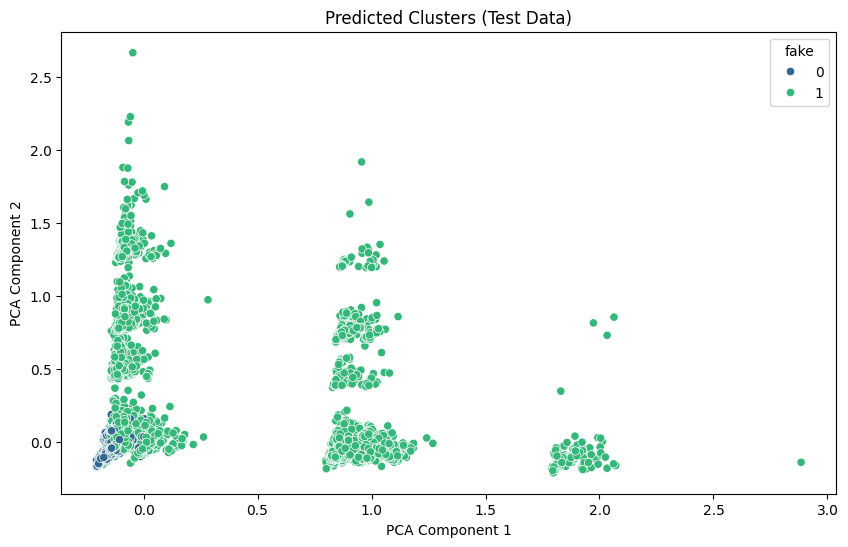

In [26]:
# visualize the classified results with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
train_pca = pca.fit_transform(xtrain_count)
test_pca = pca.transform(xvalid_count)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_pca[:,0], y=train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

DecisionTreeClassifier()
Accuracy:  0.8798
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      4954
         1.0       0.85      0.92      0.89      5046

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

[[4134  820]
 [ 382 4664]]


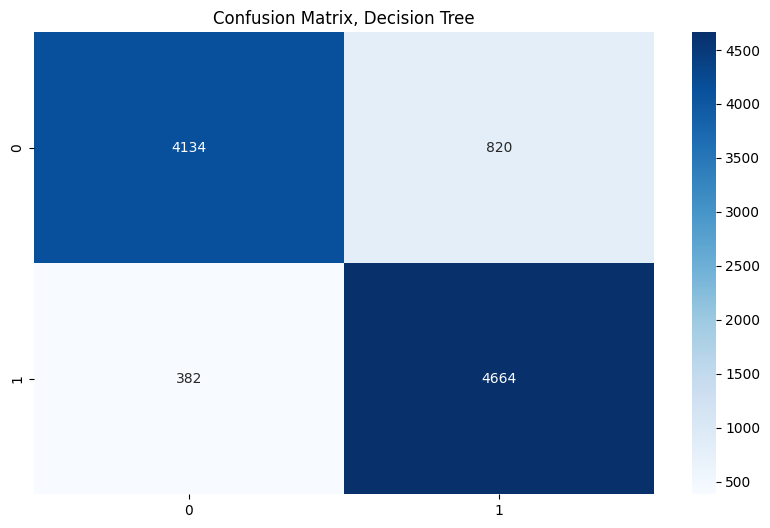

RandomForestClassifier()
Accuracy:  0.9172
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      4954
         1.0       0.90      0.94      0.92      5046

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[4445  509]
 [ 319 4727]]


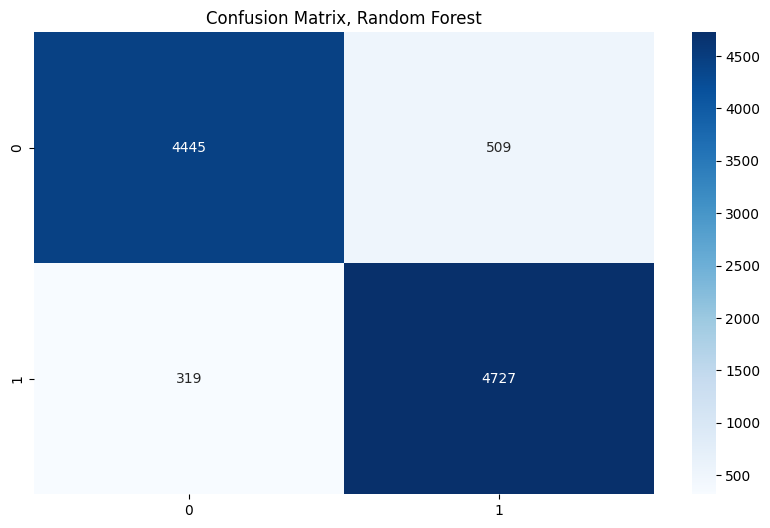

SVC(kernel='linear')
Accuracy:  0.9389
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      4954
         1.0       0.96      0.92      0.94      5046

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

[[4737  217]
 [ 394 4652]]


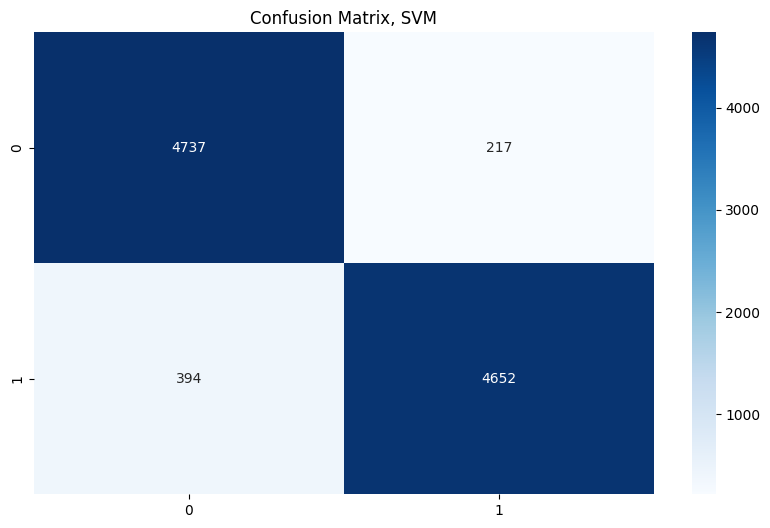

KNeighborsClassifier()
Accuracy:  0.5641
              precision    recall  f1-score   support

         0.0       0.91      0.13      0.23      4954
         1.0       0.54      0.99      0.70      5046

    accuracy                           0.56     10000
   macro avg       0.72      0.56      0.46     10000
weighted avg       0.72      0.56      0.47     10000

[[ 660 4294]
 [  65 4981]]


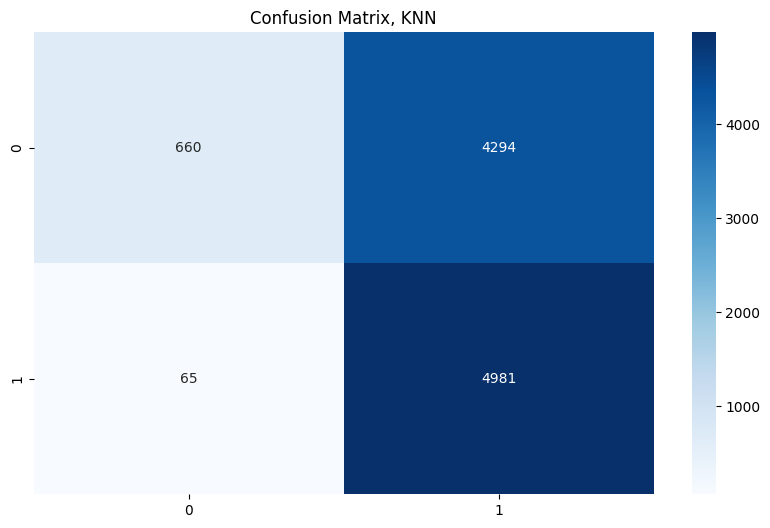

MultinomialNB()
Accuracy:  0.947
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      4954
         1.0       0.96      0.93      0.95      5046

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[4754  200]
 [ 330 4716]]


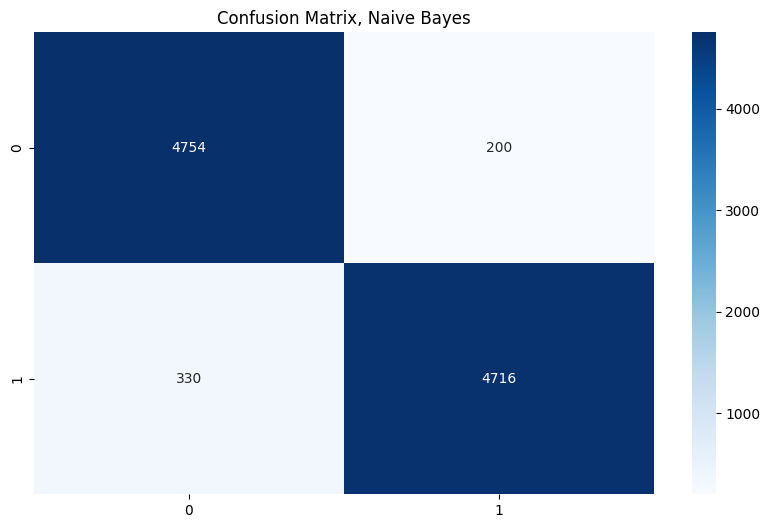

GradientBoostingClassifier()
Accuracy:  0.8042
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      4954
         1.0       0.97      0.63      0.76      5046

    accuracy                           0.80     10000
   macro avg       0.85      0.81      0.80     10000
weighted avg       0.85      0.80      0.80     10000

[[4862   92]
 [1866 3180]]


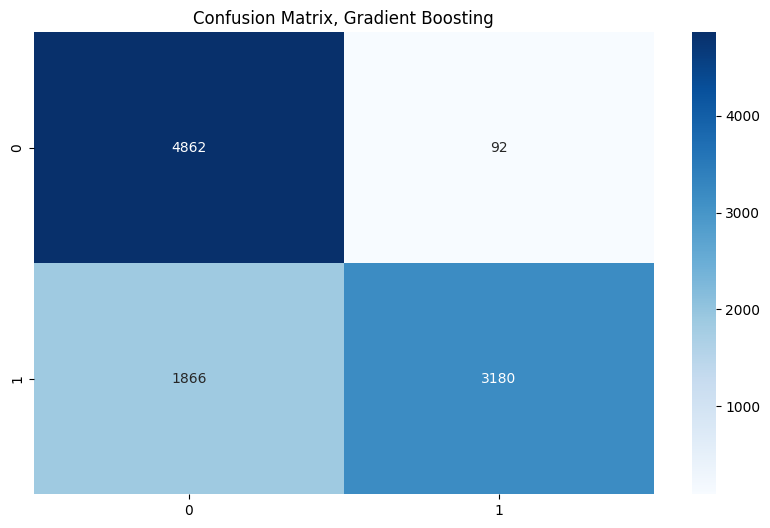

AdaBoostClassifier()


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8231
              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84      4954
         1.0       0.95      0.69      0.80      5046

    accuracy                           0.82     10000
   macro avg       0.85      0.82      0.82     10000
weighted avg       0.85      0.82      0.82     10000

[[4774  180]
 [1589 3457]]


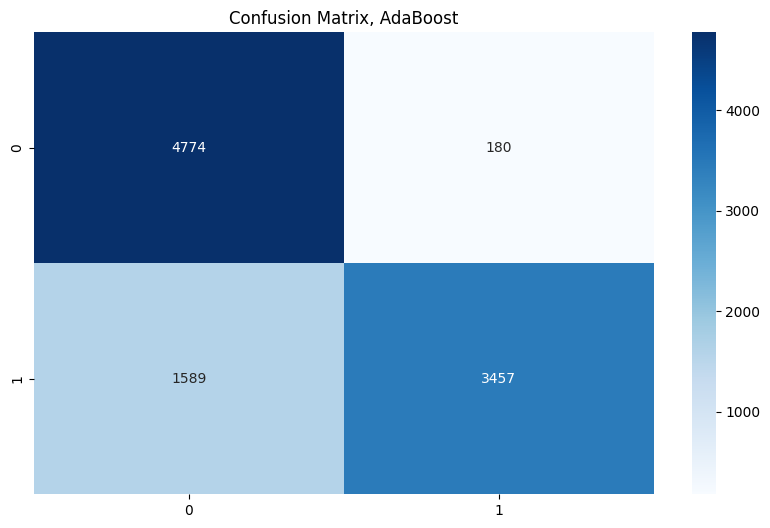

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy:  0.8796
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89      4954
         1.0       0.97      0.78      0.87      5046

    accuracy                           0.88     10000
   mac

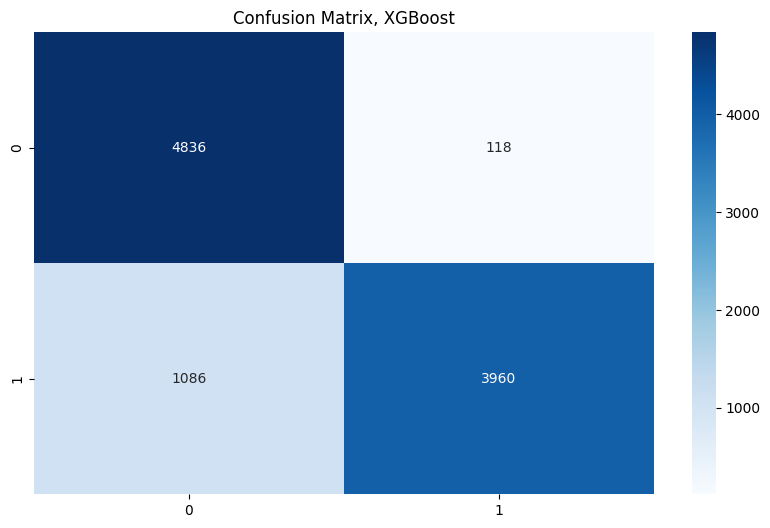

LGBMClassifier()
[LightGBM] [Info] Number of positive: 19954, number of negative: 20046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5175
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 2275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498850 -> initscore=-0.004600
[LightGBM] [Info] Start training from score -0.004600
Accuracy:  0.8976
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      4954
         1.0       0.97      0.82      0.89      5046

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

[[4814  140]
 [ 884 4162]]


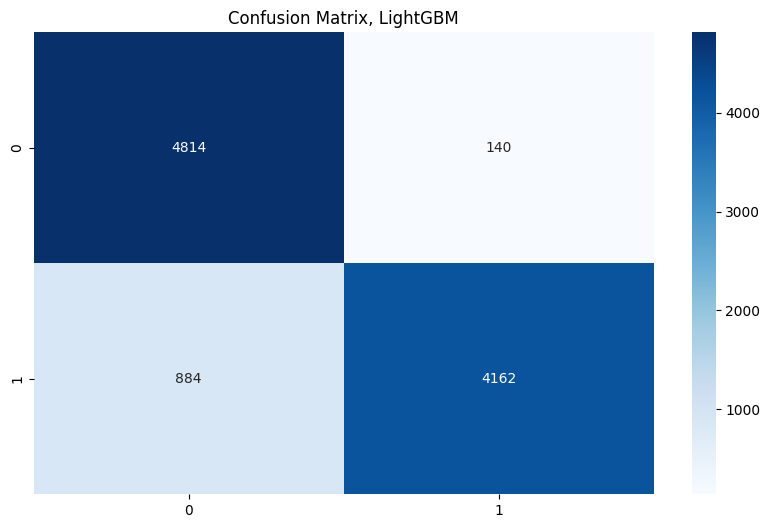

In [27]:
# Convert labels to np.float64
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

def train_model(classifier, feature_vector_train, label, feature_vector_valid,modelnames, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    print('Accuracy: ', accuracy_score(predictions, y_test))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix, {}'.format(modelnames))
    plt.show()
    
    # return accuracy_score(predictions, y_test)

# Convert tfidf_train and tfidf_test to numpy arrays
tfidf_train_array = np.asarray(tfidf_train)
tfidf_test_array = np.asarray(tfidf_test)

models = [dt, rf, svc, knn, nb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

# Count Vectors
for model, modelnames in zip(models, model_names):
    print(model)
    train_model(model, xtrain_count, y_train, xvalid_count, modelnames)
    


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 93.68 %
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DNN Confusion Matrix:
[[4619  335]
 [ 297 4749]]


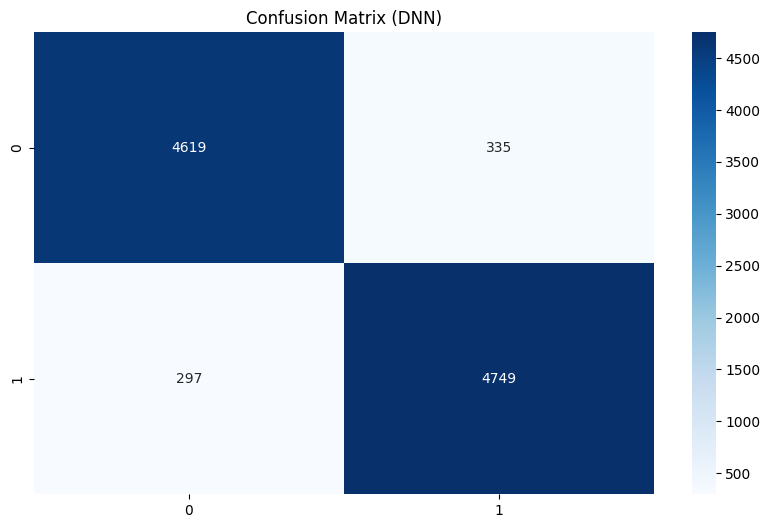

In [28]:
# DNN
neural_network = Sequential()
neural_network.add(Dense(64, input_dim=xtrain_count.shape[1], activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(xtrain_count.todense(), y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(xvalid_count.todense(),y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

# confusion matrix of DNN
y_pred = (neural_network.predict(xvalid_count.todense()) > 0.5).astype("int32")
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()


In [ ]:
# visualize the model Accuracy-DNN
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

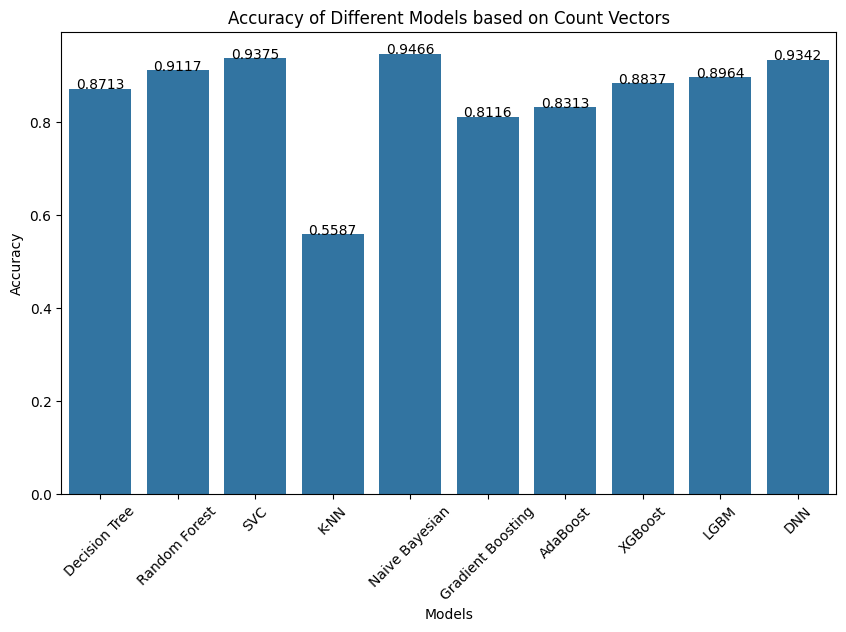

In [29]:
# visualize accuracy of different models

models = ['Decision Tree', 'Random Forest', 'SVC', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.8713, 0.9117, 0.9375, 0.5587, 0.9466, 0.8116, 0.8313, 0.8837, 0.8964, 0.9368]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on Count Vectors')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()


## Construct models use word2vec

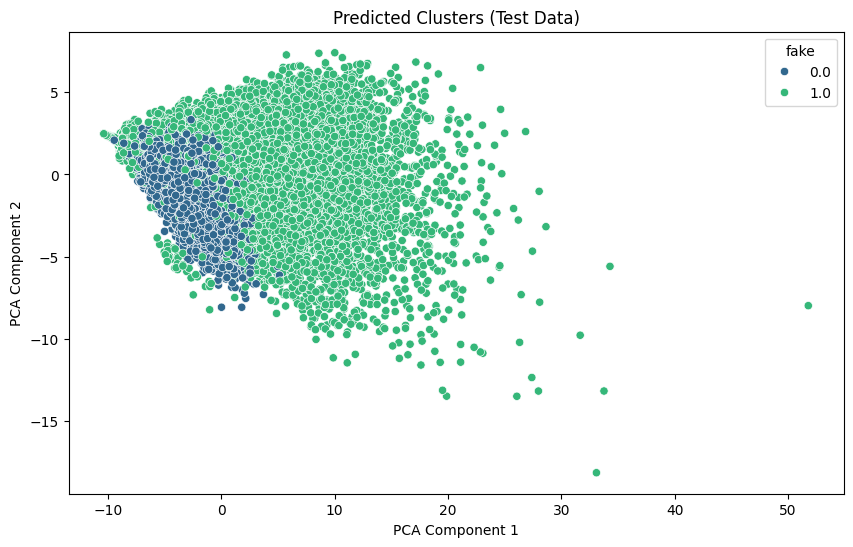

In [30]:
# construct models use word2vec
from gensim.models import Word2Vec
from gensim import utils
from sklearn.feature_extraction.text import TfidfVectorizer

# create a word2vec model
word2vec = Word2Vec([headline.split() for headline in train['headline_text']], vector_size=300, window=5, min_count=1, sg=1)

# create a vectorizer object
# tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
# tfidf_train = tfidf_vectorizer.fit_transform(x_train)
# tfidf_test = tfidf_vectorizer.transform(x_test)
# tfidf_features = tfidf_vectorizer.get_feature_names_out()

# create a function to get the vector of a sentence
def get_vector(sentence):
    vector = np.zeros(300)
    for word in sentence.split():
        try:
            vector += word2vec.wv[word]
        except:
            pass
    return vector

# create a function to get the vectors of a dataset
def get_vectors(data):
    vectors = []
    for sentence in data:
        vectors.append(get_vector(sentence))
    return np.array(vectors)

# get the vectors of the training and validation datasets
word2vec_train = get_vectors(x_train)
word2vec_test = get_vectors(x_test)

# visualize the classified results with labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
train_pca = pca.fit_transform(word2vec_train)
test_pca = pca.transform(word2vec_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_pca[:,0], y=train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Predicted Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.show()

### run model

DecisionTreeClassifier()
Accuracy:  0.87
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      4954
         1.0       0.87      0.87      0.87      5046

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

[[4316  638]
 [ 662 4384]]


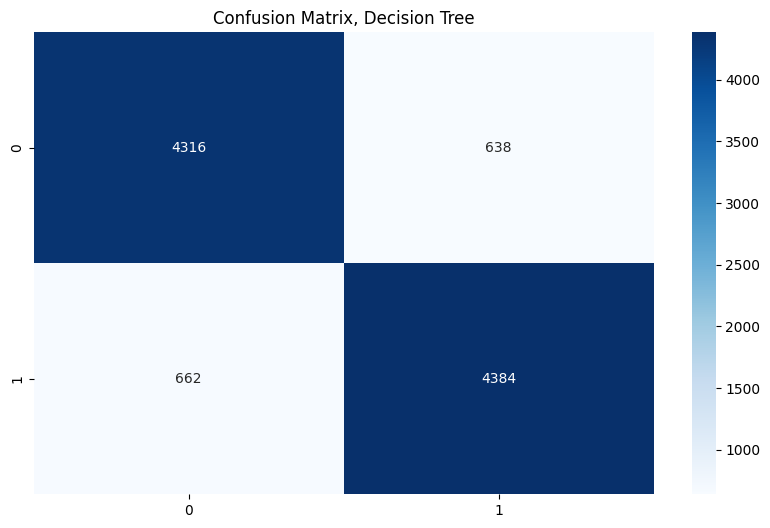

RandomForestClassifier()
Accuracy:  0.9177
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      4954
         1.0       0.95      0.88      0.92      5046

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[4728  226]
 [ 597 4449]]


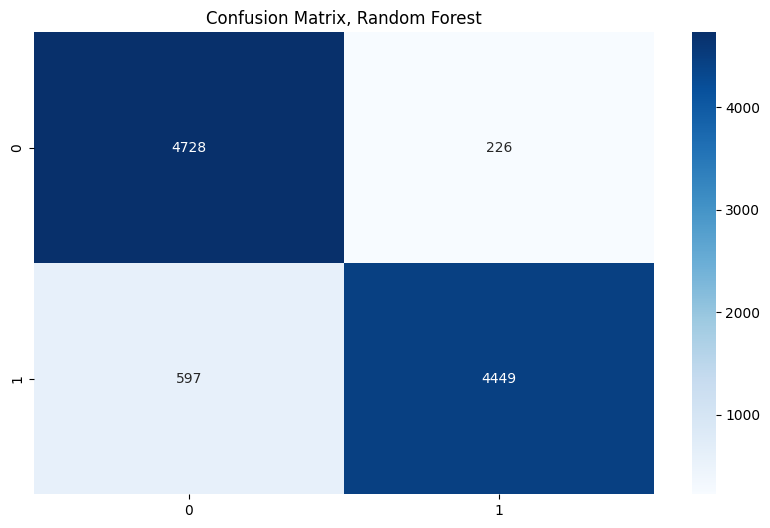

SVC(kernel='linear')
Accuracy:  0.9034
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      4954
         1.0       0.96      0.84      0.90      5046

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

[[4776  178]
 [ 788 4258]]


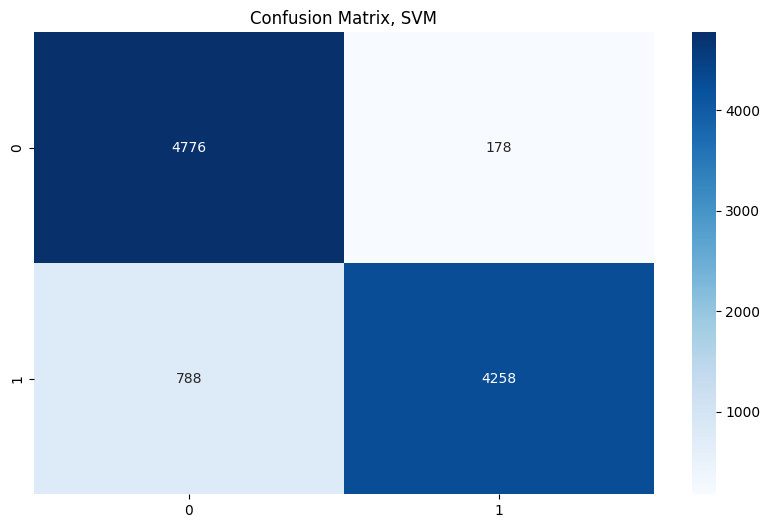

KNeighborsClassifier()
Accuracy:  0.9056
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      4954
         1.0       0.93      0.88      0.90      5046

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[4639  315]
 [ 629 4417]]


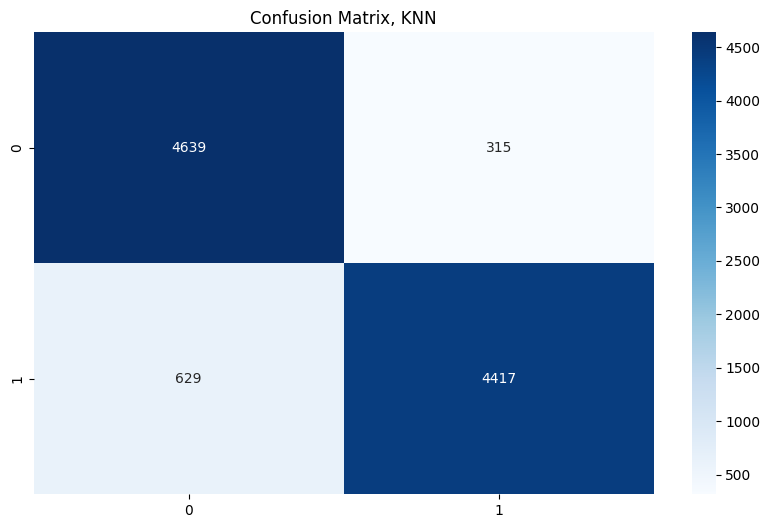

GaussianNB()
Accuracy:  0.8282
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      4954
         1.0       0.90      0.74      0.81      5046

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

[[4531  423]
 [1295 3751]]


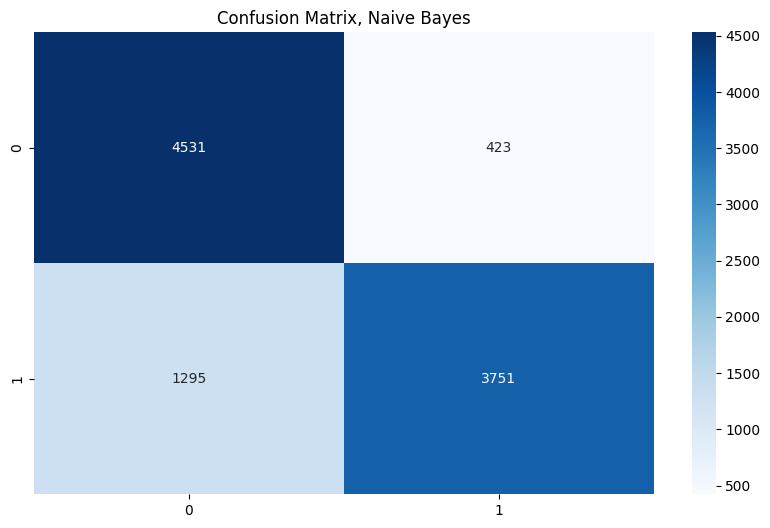

GradientBoostingClassifier()
Accuracy:  0.9103
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      4954
         1.0       0.95      0.87      0.91      5046

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

[[4698  256]
 [ 641 4405]]


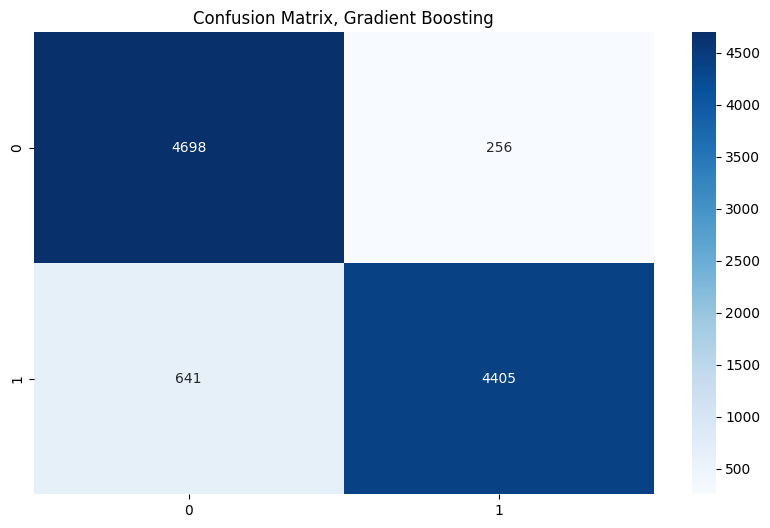

AdaBoostClassifier()


C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8995
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4954
         1.0       0.94      0.86      0.90      5046

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[4672  282]
 [ 723 4323]]


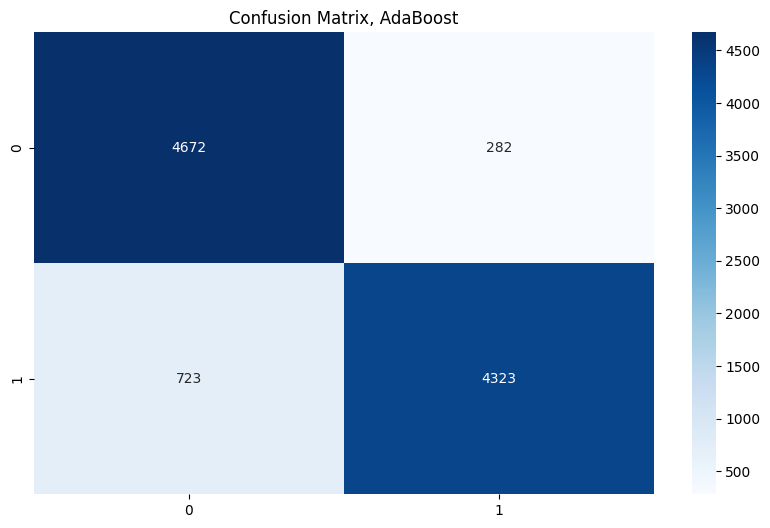

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy:  0.9203
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      4954
         1.0       0.95      0.89      0.92      5046

    accuracy                           0.92     10000
   mac

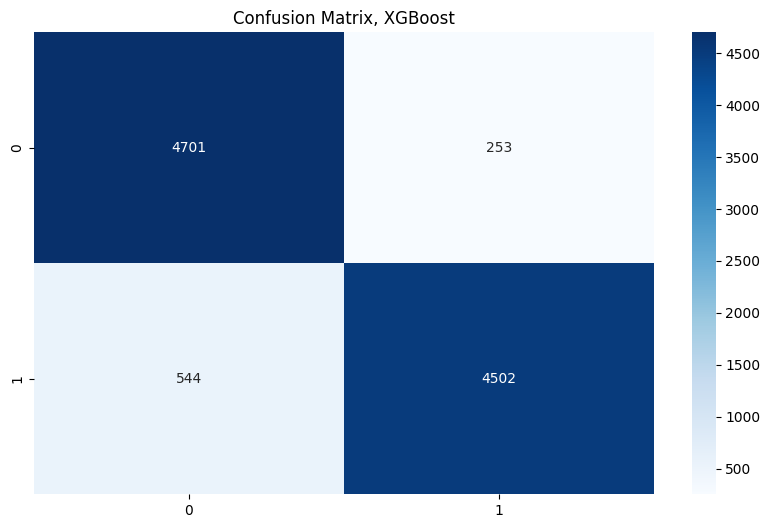

LGBMClassifier()
[LightGBM] [Info] Number of positive: 19954, number of negative: 20046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498850 -> initscore=-0.004600
[LightGBM] [Info] Start training from score -0.004600
Accuracy:  0.9212
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      4954
         1.0       0.95      0.89      0.92      5046

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

[[4732  222]
 [ 566 4480]]


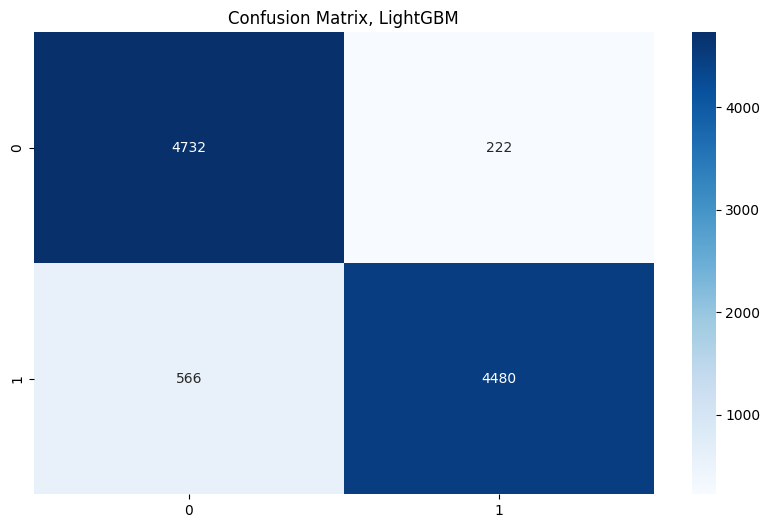

In [32]:
# construct models use word2vec

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

gaussiannb = GaussianNB()
models = [dt, rf, svc, knn, gaussiannb, gb, ada, xgb, lgbm]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LightGBM']

# Count Vectors
for model, modelnames in zip(models, model_names):
    print(model)
    train_model(model, word2vec_train, y_train, word2vec_test, modelnames)

In [33]:
# DNN
neural_network = Sequential()
neural_network.add(Dense(64, input_dim=300, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))

neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(word2vec_train, y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(word2vec_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 3)))

C:\Users\zoezh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 92.1 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
DNN Confusion Matrix:
[[4821  133]
 [ 657 4389]]


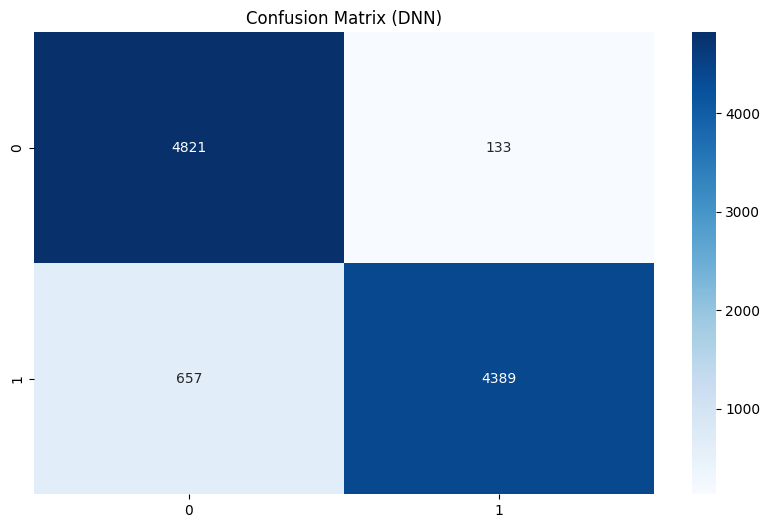

In [34]:
# confusion matrix of DNN
y_pred = (neural_network.predict(word2vec_test) > 0.5).astype("int32")
print("DNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (DNN)')
plt.show()

### accuracy

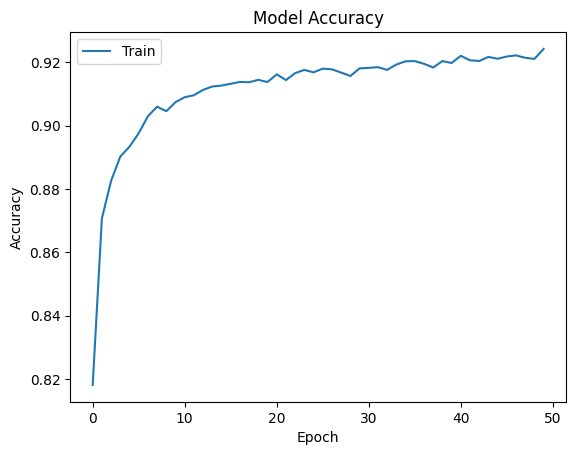

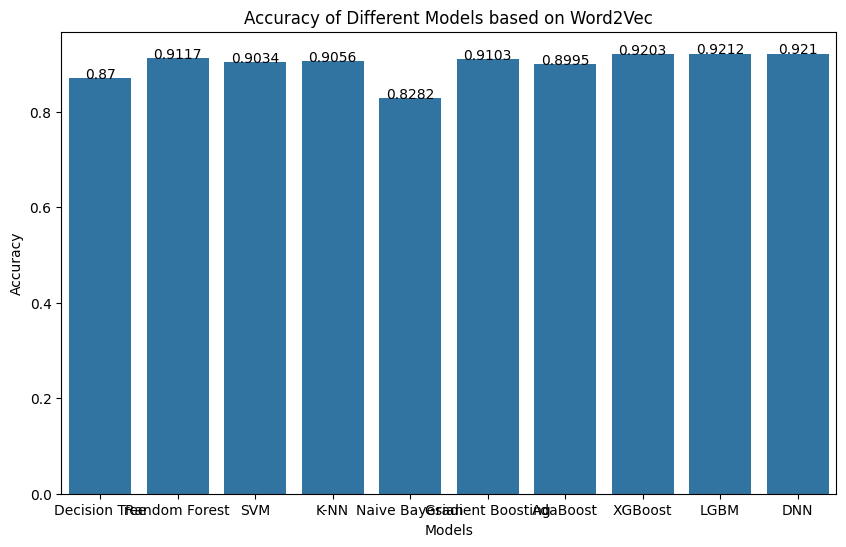

In [36]:
# visualize the model Accuracy-DNN
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# visualize accuracy of different models

models = ['Decision Tree', 'Random Forest', 'SVM', 'K-NN', 'Naive Bayesian', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'LGBM', 'DNN']
accuracy = [0.87, 0.9117, 0.9034, 0.9056, 0.8282, 0.9103, 0.8995, 0.9203, 0.9212, 0.9210]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracy)
plt.title('Accuracy of Different Models based on Word2Vec')
plt.xlabel('Models')
plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
for i in range(len(models)):
    plt.text(i, accuracy[i], accuracy[i], ha = 'center')
plt.show()
